# The Late Show with Stephen Colbert Analysis

## Standard Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import seaborn as sns
from textblob import TextBlob
import statsmodels.formula.api as smf

plt.rcParams['figure.figsize'] = (20,6)

from bokeh.plotting import output_notebook, show
output_notebook(hide_banner=True)

from IPython.display import display, HTML
def printb(*args):
    s = " ".join([str(x) for x in args])
    display(HTML('<strong>%s</strong>' % s))

hover_cols = ['episode_number', 'title', 'air_date', 'rating', 'rating_count']

from analysis_utils import create_df
from lib.analysis_utils import plot_interactive_timeseries

## Load Data

In [2]:
episodes = create_df()
episodes.head()

,episode_number,rating,rating_count,air_date,title,description,text
0,1,7.5,97.0,2015-09-08,George Clooney/Governor Jeb Bush/Mavis Staples...,"Stephen Colbert succeeds David Letterman as ""L...","OH, SAY CAN YOU SEE BY THE DAWN'S EARLY LIGHT ..."
1,2,7.5,58.0,2015-09-09,Scarlett Johansson/Elon Musk/Kendrick Lamar,Scarlett Johansson (Avengers: Age of Ultron (2...,♪ ♪ ♪ Captioning sponsored by CBS\nStephen: W...
2,3,8.6,66.0,2015-09-10,Vice President Joe Biden/Travis Kalanick/Toby ...,Vice President Joe Biden; Uber CEO Travis Kala...,(CHEERS AND APPLAUSE)\nStephen: HEY! (CHEERS A...
3,4,7.4,42.0,2015-09-11,Amy Schumer/Stephen King/Troubled Waters,Amy Schumer (Trainwreck (2015)); author Stephe...,COME ON! COME ON! ♪ ♪ ♪ ( CHEERS AND APPLAUSE ...
4,5,7.9,36.0,2015-09-14,Emily Blunt/Justice Stephen Breyer/The Dead We...,Actress Emily Blunt (Sicario (2015)); Supreme ...,"( BAND PLAYING ""LATE SHOW"" THEME ) ( CHEER..."


## Distribution of Rating and Rating Count

Number of episodes with null rating (< 5 ratings)

In [3]:
episodes.rating.isnull().sum()

17

In [4]:
episodes[['rating', 'rating_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
rating,127.0,7.578740,0.585761,5.9,7.2,7.7,8.0,9.2
rating_count,127.0,13.228346,12.287682,5.0,7.0,9.0,14.0,97.0


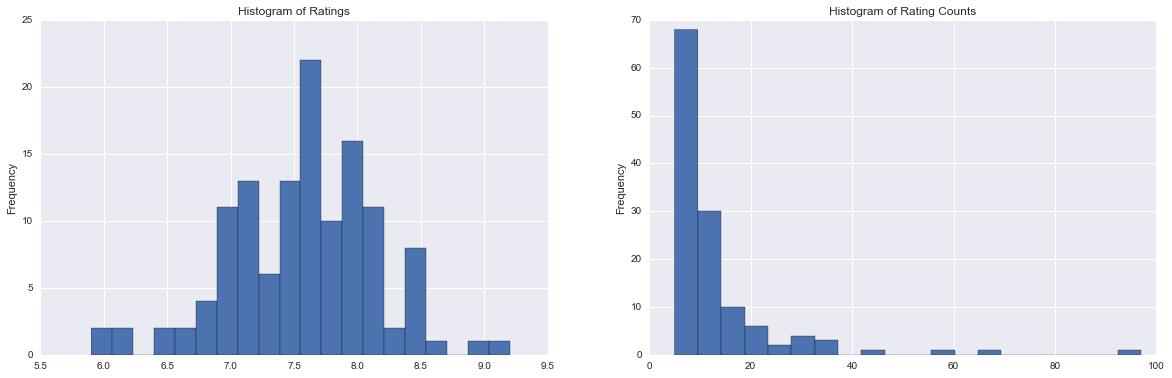

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

episodes.rating.plot(kind='hist', bins=20, ax=ax1, title="Histogram of Ratings")
episodes.rating_count.plot(kind='hist', bins=20, ax=ax2, title="Histogram of Rating Counts")

## Ratings over Time

In [6]:
p = plot_interactive_timeseries(x='air_date', y='rating', data=episodes, 
                                title="Ratings per Episode",
                               hover_cols=hover_cols)
show(p)

## Ratings Count over Time

In [7]:
p = plot_interactive_timeseries(x='air_date', y='rating_count', data=episodes, 
                                title="Number of Ratings per Episode",
                                hover_cols=hover_cols)
show(p)

## Ratings vs Rating Count

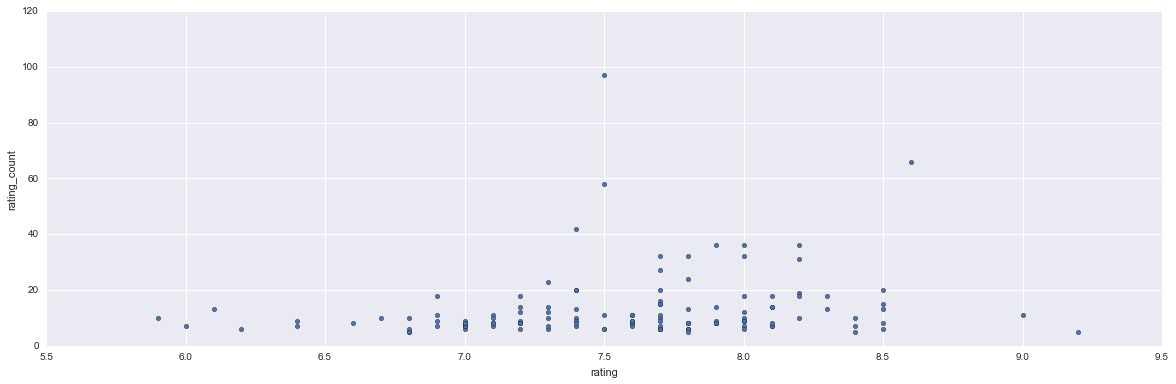

In [8]:
episodes.plot(kind='scatter', x='rating', y='rating_count')

## Sentiment Analysis

In [9]:
rows = []
for index, row in episodes.iterrows():
    if pd.isnull(row.text): continue
    blob = TextBlob(row.text)
    sentiment = blob.sentiment
    row = {"episode_number": row.episode_number, "polarity": sentiment.polarity, "subjectivity": sentiment.subjectivity}
    rows.append(row)

sentiment = pd.DataFrame(rows).set_index('episode_number')
episodes = pd.concat([episodes.set_index('episode_number'), sentiment], axis=1).reset_index()
episodes[['episode_number', 'air_date', 'polarity', 'subjectivity', 'rating', 'rating_count']].head()

,episode_number,air_date,polarity,subjectivity,rating,rating_count
0,1,2015-09-08,0.177883,0.527630,7.5,97.0
1,2,2015-09-09,0.177891,0.529692,7.5,58.0
2,3,2015-09-10,0.210318,0.500193,8.6,66.0
3,4,2015-09-11,0.148042,0.523307,7.4,42.0
4,5,2015-09-14,0.171476,0.469937,7.9,36.0


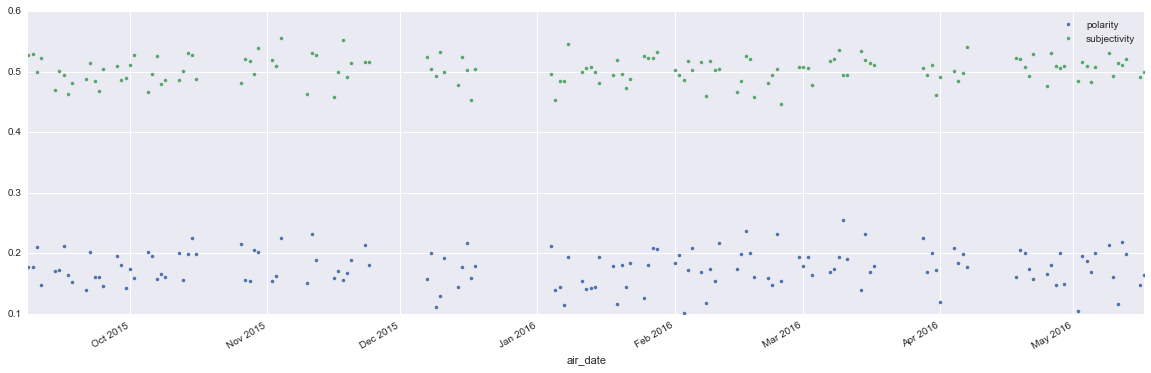

In [10]:
episodes.set_index('air_date').polarity.plot(style='.')
episodes.set_index('air_date').subjectivity.plot(style='.')
plt.legend()

In [11]:
mod = smf.ols(formula='rating ~ subjectivity + polarity', data=episodes)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.3882
Date:                Fri, 20 May 2016   Prob (F-statistic):              0.679
Time:                        22:57:54   Log-Likelihood:                -108.24
No. Observations:                 122   AIC:                             222.5
Df Residuals:                     119   BIC:                             230.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        6.5507      1.225      5.346      0.000         4.125     8.977
subjectivity     2.1932      2.489      0.881      0.380        -2.736     7.122
polarity        -0.3564      1.885     -0.189      0.850        -4.089     3.376
==============================================================================
Omnibus:                        3.405   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.182   Jarque-Bera (JB):                2.819
Skew:                          -0.321   Prob(JB):                        0.244
Kurtosis:                       3.378   Cond. No.                         58.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Subtitles of Most Recent Episodes

In [12]:
for i, row in episodes.tail(5).iterrows():
    if pd.isnull(row.text): continue
    printb(row.episode_number, row.title)
    print(row.text[:800] + '...')
    print("\n----------------------------------\n")

Captioning sponsored by CBS
Stephen: BUT I LOVE DONUTS. JUST TELL THEM TO BRING THE DONUTS. WE DON'T HAVE TO TALK ABOUT THE MOVIE. I'D LOVE TO HAVE HIM ON THE SHOW. THAT WOULD BE GREAT. LIZ.
STEPHEN.
Stephen: WE MEET AGAIN. WHAT CAN I DO FOR YOU?
IN THE BROADWAY COLD OPEN, DO YOU ACTUALLY WANT TO PARTICIPATE IN THE DANCE, OR DO YOU JUST WANT TO BANG ON A DRUM AND NOT DO MUCH GLP I'LL JUST BANG ON A DRUM.
GREAT.
Stephen: ANY OTHER FOLLOW-UP QUESTIONS.
YES, DOES THAT MEAN THEY DON'T HAVE TO COME EARLY AND REHEARSE.
Stephen: YES, I'M BEAMING UP. I WANT TO DANCE, OR I DON'T. FIND OUT.
TONIGHT, STEPHEN WELCOMES KATE BECKINSALE AND A MUSICAL PERFORMANCE BY DESIIGNER. FEATURING JON BATISTE AND STAY HUMAN. AND NOW IT'S TIME FOR "THE LATE SHOW" WITH STEPHEN COLBERT"! ( CHEERS AND APPLAUSE )
Stephen...

----------------------------------



Stephen: I AM SO EXCITED ABOUT TONIGHT'S SHOW. BOTH RYAN GOSLING AND RUSSELL CROWE ARE HERE AND I'M GOING TO STOP BY AND SAY HI. DO ALL OF YOU NEED TO BE HERE RIGHT NOW? (LAUGHTER)
YES, WE ALL NEED TO BE DOWN HERE. FOR WORK.
Stephen: OH, REALLY? SO YOU'RE NOT JUST STANDING HERE WAITING FOR RYAN GOSLING AND RUSSELL CROWE TO WALK OUT?
NO. ARE THEY ON THE SHOW TONIGHT? WE DIDN'T EVEN REALIZE. AWKWARD.
Stephen: WELL, I'M GOING TO SAY HI.
WE WILL WATCH YOU.
Announcer: TONIGHT, STEPHEN WELCOMES RYAN GOSLING AND RUSSELL CROWE! JESSIE MUELLER! AND A MUSICAL PERFORMANCE BY ANIMAL COLLECTIVE! FEATURING JON BATISTE AND "STAY HUMAN"! (CHEERS AND APPLAUSE) AND NOW IT'S TIME FOR "THE LATE SHOW" WITH STEPHEN COLBERT! (CHEERS AND APPLAUSE) ♪  Captioning sponsored by CBS ♪ ♪ ♪
Stephen: HEY! HEY, EVERYBODY!...

----------------------------------



ARE YOU READY FOR MAIRK UP?
Stephen: YEAH. I WANT TO TRY A DIFFERENT LOOK TONIGHT, THOUGH.
OKAY. ( LAUGHTER ).
Stephen: THAT'S A LITTLE TOO SALVADOR DAWLEY. SOMETHING ELSE. OOH, I LIKE McGREET, BUT I WON'T BE ABLE TO SEE MY GUESTS. SOMETHING ELSE. WOW! PICASSO IS BOLD, BUT MY GLASSES WON'T FIT. ( LAUGHTER ) JUST GIVE ME SOMETHING SIMPLE AND MASCULINE. OH, YEAH, SEXY GINGER.
TONIGHT, STEPHEN WELCOMES MATT BOMER ZACH WOODS AND A PERFORMANCE BY COMEDIAN NICK GRIFFIN. FEATURING JON BATISTE AND STAY HUMAN. AND NOW IT'S TIME FOR "THE LATE SHOW WITH STEPHEN COLBERT"! ( CHEERS AND APPLAUSE )
Stephen: HEY! HEY! BOOM! BA! WELCOME. HEY, EVERYBODY. HEY, YOU DOWN THERE. SORRY, I DROPPED MY PHONE. I DROPPED MY PHONE. I ALWAYS JUST CARRY A PHONE WITH ME. JUST IN CASE. I GOTTA GO. I GOTTA TALK TO-- SORRY,...

----------------------------------



Stephen: GOOD EVENING. I'M STEPHEN COLBERT. BEFORE WE BEGIN: A DISCLAIMER AND A  WARNING FOR VIEWERS OF TONIGHT'S EPISODE. DUE TO NEWS EVENTS BEYOND OUR CONTROL, TONIGHT'S BROADCAST OF "THE LATE SHOW" CONTAINS GRAPHIC MATERIAL, SPECIFICALLY THE PHRASE: "DONALD TRUMP KISSED VARIOUS WOMEN ON THE MOUTH." (LAUGHTER)
Stephen: I'M SORRY. THIS MATERIAL MAY BE UNSUITABLE FOR SOME VIEWERS, INCLUDING CHILDREN, ADULTS AND LIVING CREATURES WITH A MOUTH. ADDITIONALLY, VIEWERS WITH "EYES" SHOULD BE WARNED THAT WE MAY SHOW IMAGES SUCH AS THIS: THIS... OR EVEN THIS. (AUDIENCE REACTS) IT WAS A SLOW YEAR AT THE MISS UNIVERSE PAGEANT. AND ONE FINAL DISCLAIMER: THIS SHOW WILL CONTAIN REFERENCES TO THE FACT THAT DONALD TRUMP MAY BECOME PRESIDENT.  Captioning sponsored by CBS
Announcer: TONIGHT... STEPHEN WELCO...

----------------------------------



Stephen: HEY, CHRIS.
HEY, STEPHEN GR HEY, MAN, THANKS SO MUCH FOR BEING HERE. WE'RE SO EXCITED COLDPLAY IS ON THE SHOW TONIGHT.
IT LOOKS LIKE AN AMAZING SHOW.
Stephen: YEAR GOING TO HAVE A GOOD TIME.
EVERYTHING LOOKS GREAT, JUST ONE THING.
Stephen: ABOUT THE SHOW?
ABOUT THEE SONG.
Stephen: IS THEREHING WRONG WITH THE THEME
NO, THE TUNE ISAT, THE TUNE IS GREAT, BUT I FEEL LIK IT NEEDS WOR IT NEEDS LYRICS SO I'VE BEEN WORKING ON IT RIGHT HERE YOU.
Stephen:  WROTE LYRICS TO OUR THEME SONG?
I DID.
Stephen: I CAN HEAR THEM?
YOU KNOW HOW THE SHOW OPENS WITH THE DRUM SHOAL. AND SHOO-BE-DO-DOP. SHOO-DOO-DOP-DOO.
Stephen: THAT'S OUR THEME
THANKS, MAN, I'M GLAD YOU LOVE IT.
Stephen: I'M SORRY, ARE THOSE THE LYRICS?
YEAH.
Stephen: DOOBY-SHOULD, OF SHOO-BE-DO. SHOO-BE-DO-BE-DO,.
Stephen: BE-DO, YEAH.
...

----------------------------------

